<a href="https://colab.research.google.com/github/radwahashiesh/researchCode/blob/main/finalCodeMulticlass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

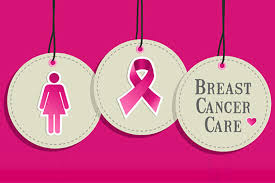\
 This file contain :\
1-Libraries \
2-Reading dataSet\
3-preparing function\
4-Building U_net model\
5-Model performace \
6-Building vgg-19 model\
7-Model performace \
8-calling function

# 1-Libraries


In [ ]:
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2- Reading DataSet

In [ ]:
path = '/content/drive/MyDrive/Dataset_BUSI_with_GT (2)/'

In [ ]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [ ]:
#x for images 
#y for masks
#t for target"label"
X_b, y_b,t_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1)),np.full(437,1) 
X_n, y_n,t_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1)),np.full(133,0) 
X_m, y_m,t_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1)),np.full(210,2) 

In [ ]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
T=np.concatenate((t_b, t_n, t_m), axis = 0)

In [ ]:
print(X.shape)
print(y.shape)
print(T.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)
(780,)


# 3-Preparing function 

In [ ]:
def convertToOneChannel(img):
   im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   i=cv2.resize(im, (128, 128))
   return i

In [ ]:
   def convertToThreeChannel(img):
       b_np= np.array(img)
       g_np= np.array(img)
       r_np= np.array(img)
       final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
       return np.array(final_img)

visualize original dataset samples

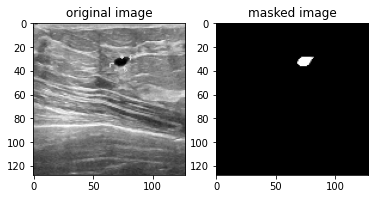

In [ ]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

# 4-Building U_net model

In [ ]:
y[y > 1.0] = 1.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, T, test_size = 0.2, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test2.shape)

(624, 128, 128, 1)
(624, 128, 128, 1)
(156,)


In [ ]:
#Contracting path


inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)
#Bottleneck layer
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

#Expanding layer
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)


In [ ]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

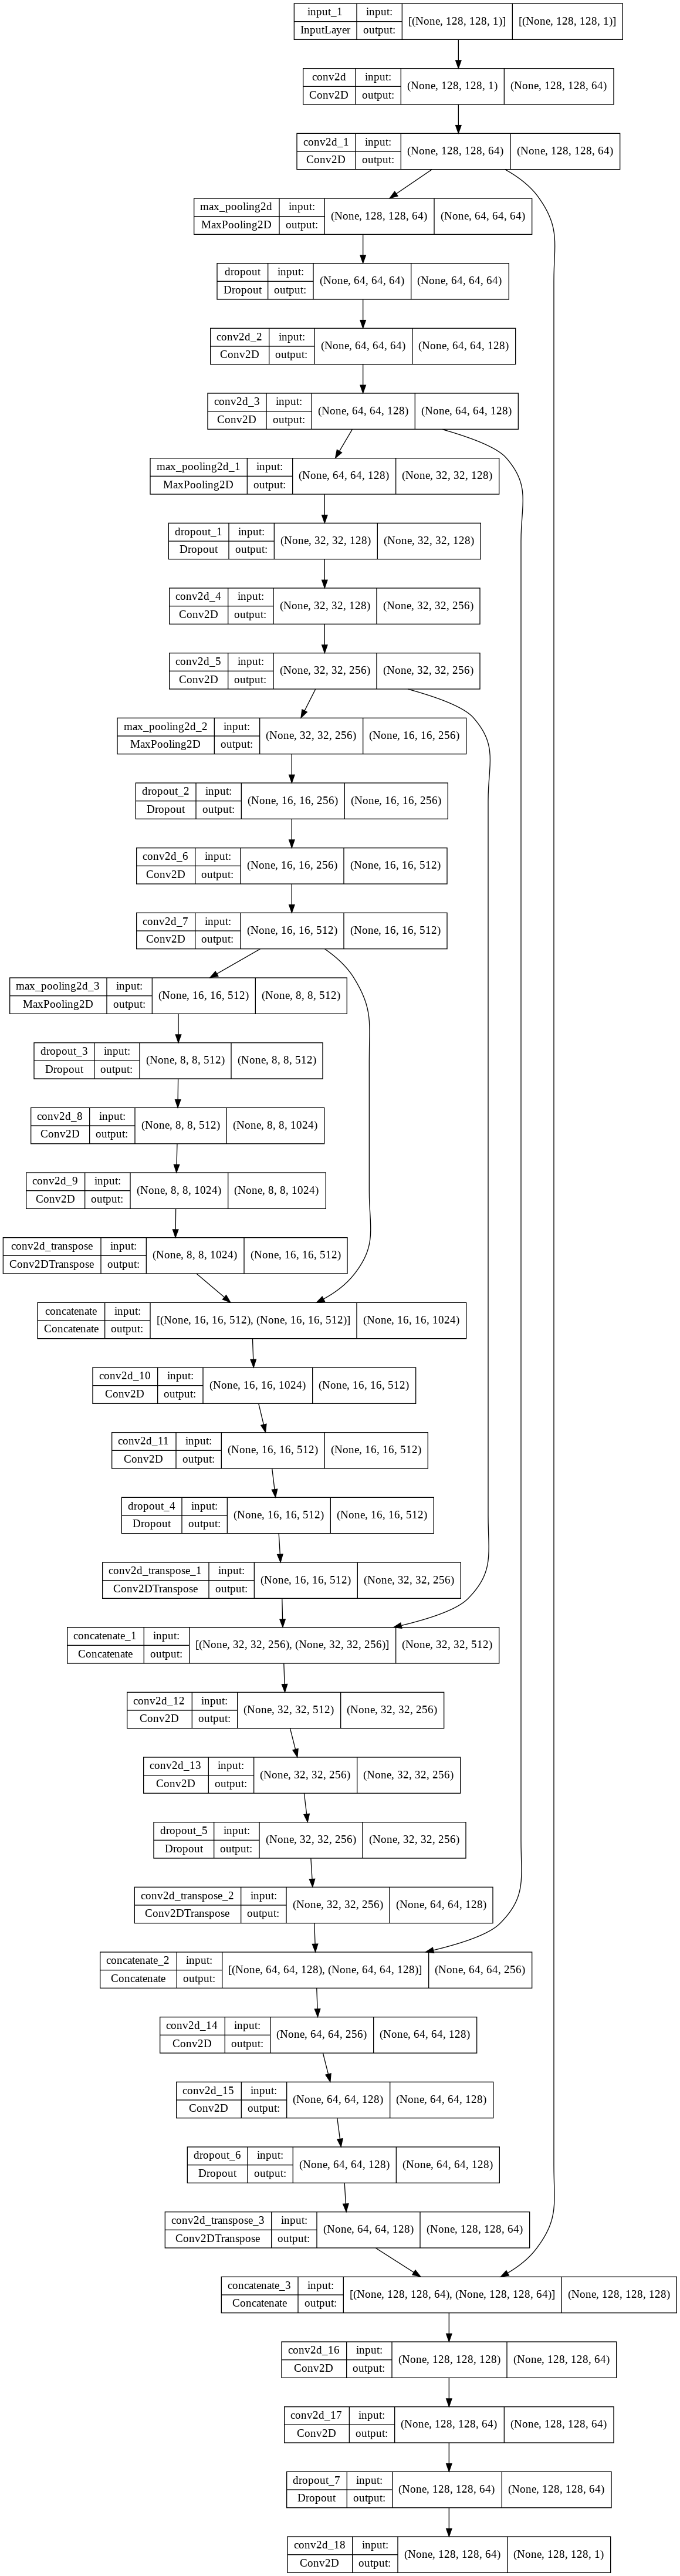

In [ ]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(X_train,y_train,batch_size = 16,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
39/39 [==============================] - 27s 269ms/step - loss: 0.0796 - acc: 0.9202 - val_loss: 0.0767 - val_acc: 0.9226
Epoch 2/100
39/39 [==============================] - 9s 221ms/step - loss: 0.0782 - acc: 0.9209 - val_loss: 0.0752 - val_acc: 0.9233
Epoch 3/100
39/39 [==============================] - 9s 221ms/step - loss: 0.0778 - acc: 0.9210 - val_loss: 0.0746 - val_acc: 0.9240
Epoch 4/100
39/39 [==============================] - 9s 223ms/step - loss: 0.0740 - acc: 0.9235 - val_loss: 0.0752 - val_acc: 0.9226
Epoch 5/100
39/39 [==============================] - 9s 225ms/step - loss: 0.0700 - acc: 0.9246 - val_loss: 0.0729 - val_acc: 0.9226
Epoch 6/100
39/39 [==============================] - 9s 226ms/step - loss: 0.0657 - acc: 0.9269 - val_loss: 0.0618 - val_acc: 0.9276
Epoch 7/100
39/39 [==============================] - 9s 228ms/step - loss: 0.0582 - acc: 0.9311 - val_loss: 0.0617 - val_acc: 0.9280
Epoch 8/100
39/39 [==============================] - 9s 229ms/step -

# 5-Model performance

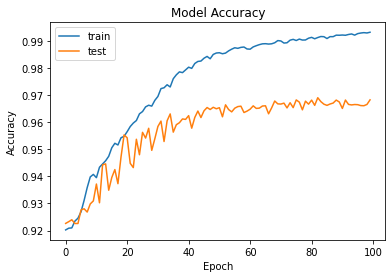

In [ ]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

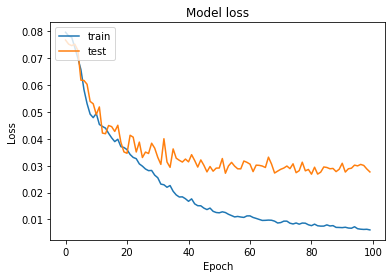

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test accuracy:', score[1]*100)

5/5 [==============================] - 6s 831ms/step - loss: 0.0277 - acc: 0.9682
Test accuracy: 96.82261347770691


In [ ]:
test=[]
test.append(y[10])
test=np.array(test)
pred=model.predict(test)
print(pred.shape)

(1, 128, 128, 1)


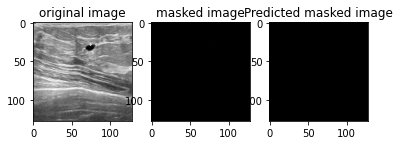

In [ ]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
predimg=convertToThreeChannel(pred[0])
plt.figure
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title("masked image")
plt.subplot(1,3,3)
plt.imshow(predimg)
plt.title("Predicted masked image")
plt.show()

#6-Building vgg-19 model

In [ ]:
t_b=np.full(437,0)
t_m=np.full(210,1) 
y1 = np.concatenate((y_b, y_m), axis = 0)
T1=np.concatenate((t_b, t_m), axis = 0)
masks=[]
for i in y:
  z=convertToThreeChannel(i)
  masks.append(z)
masks=np.array(masks)
print(masks.shape)


(780, 128, 128, 3)


In [ ]:
X_train1, X_test1, y_train1, y_test1= train_test_split(masks,T, test_size=.2, stratify=T, random_state=42)

In [ ]:
img_shape=128
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3)
)
for l in base_model.layers:
    l.trainable = False

In [ ]:
def VGG19():
    model = Sequential()
    model.add(base_model) 
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.00005),loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])
    return model

In [ ]:
model2 = VGG19()
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
history = model2.fit(X_train1,y_train1,batch_size = 20,epochs=100,validation_data=(X_test1, y_test1),callbacks=[es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 4s 92ms/step - loss: 1.5410 - acc: 0.3862 - val_loss: 0.8923 - val_acc: 0.8397
Epoch 2/100
32/32 [==============================] - 2s 56ms/step - loss: 0.8666 - acc: 0.6154 - val_loss: 0.7096 - val_acc: 0.9615
Epoch 3/100
32/32 [==============================] - 2s 56ms/step - loss: 0.6452 - acc: 0.7099 - val_loss: 0.5904 - val_acc: 0.9615
Epoch 4/100
32/32 [==============================] - 2s 56ms/step - loss: 0.5028 - acc: 0.7853 - val_loss: 0.4934 - val_acc: 0.9679
Epoch 5/100
32/32 [==============================] - 2s 56ms/step - loss: 0.4573 - acc: 0.8109 - val_loss: 0.4042 - val_acc: 0.9744
Epoch 6/100
32/32 [==============================] - 2s 56ms/step - loss: 0.3904 - acc: 0.8526 - val_loss: 0.3442 - val_acc: 0.9744
Epoch 7/100
32/32 [==============================] - 2s 56ms/step - loss: 0.4050 - acc: 0.8381 - val_loss: 0.2818 - val_acc: 0.9744
Epoch 8/100
32/32 [==============================] - 2s 57ms/step - loss: 0.3546 - acc: 

#7- Model performance

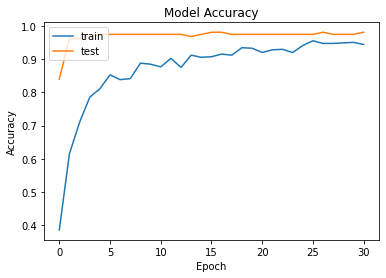

In [ ]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

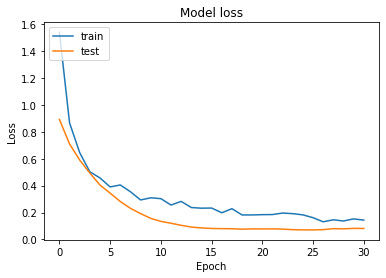

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Generate generalization metrics
y_predictt = model2.predict(X_test1)
y_predictt = y_predictt.argmax(axis=-1)
score=accuracy_score(y_test1, y_predictt)*100
print('Accuracy of testing: \n{0}'.format(score))
pred = model2.predict_generator(X_test1)
y_predict = pred.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test1, y_predict)
print('Confusion matrix of testing: \n{0}'.format(conf_mx))
print(classification_report(y_test1, y_predict))

Accuracy of testing: 
97.43589743589743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion matrix of testing: 
[[27  0  0]
 [ 0 86  1]
 [ 0  3 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.97      0.99      0.98        87
           2       0.97      0.93      0.95        42

    accuracy                           0.97       156
   macro avg       0.98      0.97      0.98       156
weighted avg       0.97      0.97      0.97       156



In [ ]:
print(y_predictt)

[1 0 2 1 0 1 1 2 0 1 2 1 0 1 1 1 1 1 1 1 0 1 2 2 2 1 1 0 2 1 1 1 0 0 1 1 1
 1 2 1 1 1 0 0 1 2 1 1 1 0 1 2 1 0 2 1 1 1 2 2 1 2 1 1 1 1 2 1 2 2 1 2 1 1
 2 2 2 1 1 0 1 1 1 1 2 1 1 1 1 1 1 2 0 1 1 1 1 1 2 2 1 1 2 1 2 0 2 2 1 0 0
 1 2 1 1 1 1 1 1 0 1 2 1 1 1 0 1 2 0 1 1 1 2 1 2 0 2 1 0 2 1 2 0 0 1 1 0 1
 1 2 0 1 0 2 1 2]


In [ ]:
mask=model.predict(X_test)
mask=np.array(mask)
print(mask.shape)
mask3channel=[]
for i in mask:
  img=convertToThreeChannel(i)
  mask3channel.append(img)
mask3channel=np.array(mask3channel)
print(mask3channel.shape)
x=model2.predict(mask3channel)
value=x.argmax(axis=-1))

(156, 128, 128, 1)
(156, 128, 128, 3)
[0 0 0 1 0 0 1 1 2 1 0 0 2 1 2 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 2 0 0 1 1 1 0 0 1 2 0 1 0 2 0 1 0 2 2 0 1 0 1 0 0 0 2 1 1 2 2 0 0 0 1 1 0
 0 2 1 0 0 0 1 0 0 0 2 1 1 1 0 2 2 1 1 0 1 0 0 0 2 0 1 0 1 1 0 1 0 0 2 0 0
 2 1 0 2 1 0 1 2 2 1 1 0 0 2 0 1 0 0 2 1 1 2 2 0 1 0 0 1 0 0 1 1 0 1 1 0 1
 0 0 2 1 0 0 1 0]


8-calling function 

In [ ]:
def evaluate(path):
    img = cv2.imread(path)
    test=[]
    i=convertToOneChannel(img)
    test.append(i)
    test=np.array(test)
    print(test.shape)
    mask=model.predict(test)
    mask=np.array(mask)
    print(mask.shape)
    prediction=convertToThreeChannel(mask[0])
    sample=[]
    sample.append(prediction)
    sample=np.array(sample)
    x=model2.predict(sample)
    value=x.argmax(axis=-1)
    if (value==0):
        print("normal")
    elif (value==1):
        print("benign")
    else:
      print("malignant")

In [ ]:
evaluate("/content/drive/MyDrive/Dataset_BUSI_with_GT (3)/upnormal/benign (1).png")

(1, 128, 128)
(1, 128, 128, 1)
benign


In [ ]:
evaluate("/content/drive/MyDrive/Dataset_BUSI_with_GT (3)/normal/normal (1).png")

(1, 128, 128)
(1, 128, 128, 1)
normal


In [ ]:
evaluate("/content/drive/MyDrive/Dataset_BUSI_with_GT (3)/upnormal/malignant (120).png")

(1, 128, 128)
(1, 128, 128, 1)
normal
